In [17]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

In [18]:
PROJECT_ID = 'york-bb-cohort'
BQ_LOCATION = 'US'
REGION = 'us-west1'
GCS_BUCKET = f"{PROJECT_ID}-k_capbucket"

BQ_DATASET = f"{PROJECT_ID}:p_bq"

In [122]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW p_bq.ml_features AS (
    
SELECT 
    DISTINCT(CONCAT(visitId, hits.hitNumber)) AS unique_id,
    IF(hits.eCommerceAction.action_type = '3', 1, 0) AS Target,
    IFNULL(CAST(totals.pageviews AS INT64), 0) AS pageviews, 
    IFNULL(CAST(totals.timeOnSite AS INT64), 0) AS timeOnSite,  
    IFNULL(device.browser, "Unknown") AS browser, 
    IFNULL(geoNetwork.country, "Unknown") AS country, 
    IFNULL(geoNetwork.city,'') AS city, 
    IFNULL(hits.hitNumber, 0) AS hitNumber, 
    IFNULL(hits.time, 0) AS Time,
    IFNULL(hits.hour, 0) AS hour,
    IFNULL(hits.type, '') AS hitType,

    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId, hits.hitNumber)) , 10)) <= 7
        THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId, hits.hitNumber)) , 10)) = 8
        THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId, hits.hitNumber)) , 10)) = 9
        THEN 'TEST'    
      ELSE '' END AS data_split
    
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201703*` AS final, 
UNNEST(hits) AS hits
);

SELECT *
FROM p_bq.ml_features
LIMIT 5;



Query is running:   0%|          |

Downloading:   0%|          |

,unique_id,Target,pageviews,timeOnSite,browser,country,city,hitNumber,Time,hour,hitType,data_split
0,825208713339150867514889161571,0,1,0,Chrome,Ireland,Dublin,1,0,11,PAGE,TRAIN
1,005722183255531111814889020341,0,1,0,Chrome,United States,Seattle,1,0,7,PAGE,TRAIN
2,36960218843501093914889557051,0,1,0,Firefox,India,not available in demo dataset,1,0,22,PAGE,EVAL
3,761427394943913937914889078901,0,1,0,Chrome,United States,Cambridge,1,0,9,PAGE,TRAIN
4,784132577524108316914889499101,0,1,0,Chrome,Sri Lanka,not available in demo dataset,1,0,21,PAGE,TEST


In [124]:
%%bigquery

CREATE OR REPLACE MODEL p_bq.ml_model

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["target"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT
  * EXCEPT(unique_id)
FROM
 p_bq.ml_features


Query is running:   0%|          |

""


In [125]:

%%bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL asmi_bq.ml_model)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.0,0.0,0.976305,0.0,0.141081,0.744391


In [126]:
%%bigquery
CREATE OR REPLACE VIEW p_bq.ml_features2 AS (
  SELECT
    unique_id,
    action_type,
    visitNumber,
    IFNULL(pageviews_per_session, 0) AS pageviews,
    IFNULL(time_on_site, 0) AS time_on_site,
    IFNULL(traffic_source, '') AS traffic_source,
    IFNULL(device_category, '') AS device_category,
    IFNULL(country, '') AS country,
    IFNULL(city, '') AS city,
    IFNULL(operating_system, '') AS operating_system,
    IFNULL(traffic_campaign, '') AS traffic_campaign,
    IFNULL(visits, 0) AS visits,
    IFNULL(hits,0) As hits,
    -- BQML Hyperparameter tuning requires STRING 3 partition data_split column.
    -- 80% 'TRAIN' | 10%'EVAL' | 10% 'TEST'
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) <= 7 THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 8 THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 9 THEN 'TEST'
      ELSE '' 
    END AS data_split
  FROM
    `york-bb-cohort.p_bq.data`
);

SELECT * FROM p_bq.ml_features2
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

,unique_id,action_type,visitNumber,pageviews,time_on_site,traffic_source,device_category,country,city,operating_system,traffic_campaign,visits,hits,data_split
0,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
1,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
2,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
3,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
4,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
5,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
6,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
7,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
8,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN
9,7996113244876124699_14892390253,0,1,13,342,google,desktop,Singapore,(not set),Macintosh,(not set),1,14,TRAIN


In [7]:
MODEL_NAME="preet_model"

In [128]:
%%bigquery

CREATE OR REPLACE MODEL p_bq.preet_model

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["action_type"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT
  * EXCEPT(unique_id)
FROM
 p_bq.ml_features2


Query is running:   0%|          |

""


In [129]:
%%bigquery --project $PROJECT_ID

SELECT
  data_split,
  COUNT(*) AS n_examples
FROM p_bq.ml_features2
GROUP BY data_split

Query is running:   0%|          |

Downloading:   0%|          |

,data_split,n_examples
0,TEST,116444
1,TRAIN,925161
2,EVAL,115777


In [130]:

%%bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL p_bq.preet_model)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.017955,0.895973,0.62296,0.035204,0.53556,0.827895


In [131]:
%%bigquery df_ml_features2 --project $PROJECT_ID

SELECT 
    * 
FROM 
   p_bq.ml_features2

Query is running:   0%|          |

Downloading:   0%|          |

In [133]:
df_ml_features2.shape

(1157382, 14)

In [19]:
%%bigquery
SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL  p_bq.preet_model)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,71739,43811
1,1,93,801


In [20]:
%%bigquery df_roc 

SELECT * FROM ML.ROC_CURVE(MODEL p_bq.preet_model)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

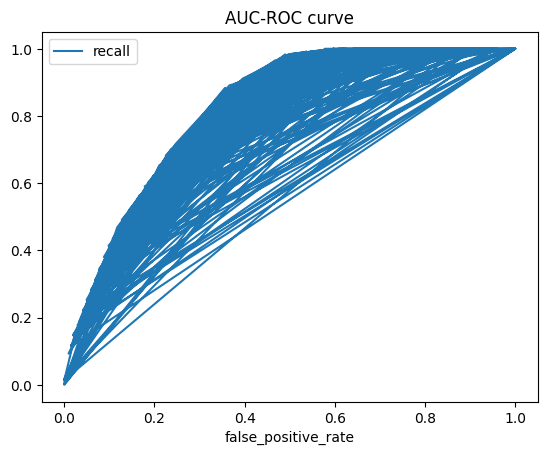

In [21]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [22]:
%%bigquery df_ROC_AUC --project $PROJECT_ID

SELECT
    recall,
    true_positives / (true_positives + false_positives) AS precision
FROM
  ML.ROC_CURVE(MODEL p_bq.preet_model,
    TABLE `p_bq.ml_features2`)

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL p_bq.preet_model)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,1,hits,0.523613
1,1,pageviews,0.140162
2,1,visitNumber,0.037659
3,1,time_on_site,0.017134
4,1,traffic_source,0.012879
5,1,country,0.012481
6,1,operating_system,0.011711
7,1,city,0.003736
8,1,device_category,0.001580
9,1,traffic_campaign,0.000192


In [24]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL p_bq.preet_model,
  (SELECT * FROM p_bq.ml_features2 WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_action_type,predicted_action_type_probs,unique_id,action_type,visitNumber,pageviews,time_on_site,traffic_source,device_category,country,city,operating_system,traffic_campaign,visits,hits,data_split
0,1,1,"[{'label': 1, 'prob': 0.6459565162658691}, {'l...",1086588710502217257_14899330223,0,1,3,123,google,tablet,United States,not available in demo dataset,Android,(not set),1,4,TEST
1,1,0,"[{'label': 1, 'prob': 0.13353997468948364}, {'...",9101674173985279230_14899567092,0,1,4,214,(direct),desktop,United States,New York,Macintosh,(not set),1,4,TEST
2,1,0,"[{'label': 1, 'prob': 0.13353997468948364}, {'...",9101674173985279230_14899567092,0,1,4,214,(direct),desktop,United States,New York,Macintosh,(not set),1,4,TEST
3,1,0,"[{'label': 1, 'prob': 0.13353997468948364}, {'...",9101674173985279230_14899567092,0,1,4,214,(direct),desktop,United States,New York,Macintosh,(not set),1,4,TEST
4,1,0,"[{'label': 1, 'prob': 0.13353997468948364}, {'...",5026906175471538414_14899369942,0,1,4,69,google,desktop,Bulgaria,not available in demo dataset,Windows,(not set),1,4,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116439,1,1,"[{'label': 1, 'prob': 0.5355055332183838}, {'l...",6443070651859885456_148866073819,0,1,14,148,google,mobile,Canada,not available in demo dataset,iOS,AW - Accessories,1,19,TEST
116440,1,1,"[{'label': 1, 'prob': 0.5355055332183838}, {'l...",6443070651859885456_148866073819,0,1,14,148,google,mobile,Canada,not available in demo dataset,iOS,AW - Accessories,1,19,TEST
116441,1,1,"[{'label': 1, 'prob': 0.5355055332183838}, {'l...",6443070651859885456_148866073819,0,1,14,148,google,mobile,Canada,not available in demo dataset,iOS,AW - Accessories,1,19,TEST
116442,1,1,"[{'label': 1, 'prob': 0.5355055332183838}, {'l...",6443070651859885456_148866073819,0,1,14,148,google,mobile,Canada,not available in demo dataset,iOS,AW - Accessories,1,19,TEST


In [25]:
%%bigquery 

CREATE OR REPLACE TABLE p_bq.action_type_predictions AS (
SELECT
    unique_id,
    action_type,
    predicted_action_type,
    predicted_action_type_probs AS predicted_action_type_prob
FROM
  ML.PREDICT(MODEL p_bq.preet_model,
  (SELECT * FROM p_bq.ml_features2))
);

Query is running:   0%|          |

""


In [9]:
%%bigquery prediction_final
select * from p_bq.action_type_predictions

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
print('Actual', prediction_final['action_type'].value_counts())
print('Predicted',prediction_final['predicted_action_type'].value_counts())

Actual action_type
0    1148600
1       8782
Name: count, dtype: Int64
Predicted predicted_action_type
0    717636
1    439746
Name: count, dtype: Int64


In [27]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

actual = prediction_final['action_type']
predicted = prediction_final['predicted_action_type']

# Calculate recall
recall = recall_score(actual, predicted)

# Calculate precision
precision = precision_score(actual, predicted)

# Calculate accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 score
f1 = f1_score(actual, predicted)

# Calculate ROC AUC score
roc_auc = roc_auc_score(actual, predicted)

# Print the metrics
print('Recall:', recall)
print('Precision:', precision)
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('ROC AUC Score:', roc_auc)


Recall: 0.904008198588021
Precision: 0.0180536036712102
Accuracy: 0.6261821939515216
F1 Score: 0.035400242571255305
ROC AUC Score: 0.7640330911101345


In [28]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

Exporting model to bucket

In [29]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r5d6d404c845fcc46_0000018dc381ab6a_1 ... (6s) Current status: DONE   


In [30]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [31]:
#Upload BQML model to Vertex AI from GC Storage
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-central1/models/9110428003426369536/operations/5127348107041832960
Model created. Resource name: projects/319407066227/locations/us-central1/models/9110428003426369536@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-central1/models/9110428003426369536@1')


In [32]:
# Deploy model to endpoint

endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-central1/endpoints/8939462741400223744/operations/8336162944622526464
Endpoint created. Resource name: projects/319407066227/locations/us-central1/endpoints/8939462741400223744
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-central1/endpoints/8939462741400223744')
Deploying model to Endpoint : projects/319407066227/locations/us-central1/endpoints/8939462741400223744
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-central1/endpoints/8939462741400223744/operations/6899514663491338240
Endpoint model deployed. Resource name: projects/319407066227/locations/us-central1/endpoints/8939462741400223744


In [33]:
%%bigquery df_cat_features --project $PROJECT_ID

SELECT * 
FROM p_bq.ml_features2

Query is running:   0%|          |

Downloading:   0%|          |

In [35]:
for col in df_cat_features.columns:
    print(col,":",df_cat_features[col].dtype)

unique_id : object
action_type : Int64
visitNumber : Int64
pageviews : Int64
time_on_site : Int64
traffic_source : object
device_category : object
country : object
city : object
operating_system : object
traffic_campaign : object
visits : Int64
hits : Int64
data_split : object


In [36]:
CAT_FEATURES = [col for col in df_cat_features.columns if (df_cat_features[col].dtype==object and col!= "unique_id" and col!= "data_split")]
CAT_FEATURES

['traffic_source',
 'device_category',
 'country',
 'city',
 'operating_system',
 'traffic_campaign']

In [39]:
# Bring in ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

In [163]:
# CATEGORICAL_FEATURES = []
    
# for idx, feature in enumerate(CAT_FEATURES):
#     feature_vocab_file = f"gs://{GCS_BUCKET}/{MODEL_NAME}/assets/{idx}_categorical_label.txt"
#     CATEGORICAL_FEATURES.append(feature_vocab_file)
# print(CATEGORICAL_FEATURES)

['gs://york-bb-cohort-k_capbucket/preet_model/assets/0_categorical_label.txt', 'gs://york-bb-cohort-k_capbucket/preet_model/assets/1_categorical_label.txt', 'gs://york-bb-cohort-k_capbucket/preet_model/assets/2_categorical_label.txt', 'gs://york-bb-cohort-k_capbucket/preet_model/assets/3_categorical_label.txt', 'gs://york-bb-cohort-k_capbucket/preet_model/assets/4_categorical_label.txt', 'gs://york-bb-cohort-k_capbucket/preet_model/assets/5_categorical_label.txt']


In [40]:
CATEGORICAL_FEATURES = []

for idx, feature in enumerate(CAT_FEATURES):
    feature_vocab_file = f"gs://{GCS_BUCKET}/{MODEL_NAME}/assets/{idx}_categorical_label.txt"
    CATEGORICAL_FEATURES.append((feature, feature_vocab_file))

feature_encoders = {}

for feature, feat_file in CATEGORICAL_FEATURES:
    feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    feature_vocab_df = pd.read_csv(feat_file, delimiter="\t", header=None).fillna('Unknown')
    feature_encoder.fit(feature_vocab_df.values)
    feature_encoders[feature] = feature_encoder

feature_encoders


{'traffic_source': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'device_category': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'country': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'city': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'operating_system': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
 'traffic_campaign': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)}

In [41]:
# Transform instances to numerical values for inference
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)
    return transformed_instances

In [44]:
%%bigquery test_df --project $PROJECT_ID

SELECT * EXCEPT(unique_id, action_type, data_split)
FROM p_bq.ml_features2
WHERE data_split="TEST"
LIMIT 2;

Query is running:   0%|          |

Downloading:   0%|          |

In [45]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name
test_instances = test_df.astype(str).to_dict(orient='records')

In [46]:
# Preprocess to transform categorical features and return numberical instances for prediction
transformed_test_instances = preprocess_xgboost(test_instances, CAT_FEATURES, feature_encoders)

In [47]:
# Generate predictions from model deployed to VertexAI endpoint
predictions = endpoint.predict(instances=transformed_test_instances)

In [49]:
for idx, prediction in enumerate(predictions.predictions):
    # class lables taken from model_metadata.json in gcs model directory
    # BQ ML bin classification with 0.5 and above being a prediction of add to cart
    action_type = "Will Add to Cart" if prediction[0] >= 0.5 else "Will Not Add to Cart"
    print(f"Prediction: Customer {idx} - {action_type} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Will Not Add to Cart [0.1640899032354355, 0.8359101414680481]
{"visitNumber":"1","pageviews":"1","time_on_site":"0","traffic_source":"google","device_category":"desktop","country":"United Kingdom","city":"not available in demo dataset","operating_system":"Windows","traffic_campaign":"(not set)","visits":"1","hits":"1"}

Prediction: Customer 1 - Will Not Add to Cart [0.1640899032354355, 0.8359101414680481]
{"visitNumber":"1","pageviews":"1","time_on_site":"0","traffic_source":"google","device_category":"desktop","country":"United Kingdom","city":"not available in demo dataset","operating_system":"Windows","traffic_campaign":"(not set)","visits":"1","hits":"1"}

